# Exploring how crime in San Franciso varies by month, day, hour and year

A few things to note before getting started: 
* The data spans 1/1/2003 to 5/13/2015, and Kaggle separated it into training and test sets by alternating the weeks, i.e the first week would go into the training set, the second into the test set, the third into the training set and so on.

Ready? Let's get going by importing some packages and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams['axes.titlesize'] = 18

train = pd.read_csv('input/train.csv', parse_dates=['Dates'])
test = pd.read_csv('input/test.csv', parse_dates=['Dates'])

The first step in our analysis is to parse the values in the Dates column into pieces that will allow us to better explore the data. We do that in the parseDate function below, then combine the train and test sets.  

In [2]:
def parseDate(df):
    df['dayOfMonth'] = df.Dates.dt.day
    df['dayOfWeek'] = df.Dates.dt.dayofweek

    df['month'] = df.Dates.dt.month
    df['year'] = df.Dates.dt.year
    df['hour'] = df.Dates.dt.hour
    
    return df

train = parseDate(train)
test = parseDate(test)
allData = pd.concat([train, test]).sort_values(by='Dates')

## Is there a seasonal variation in the number of crimes commited?

The first angle we'll examine is seasonal variation. Let's look at some plots.

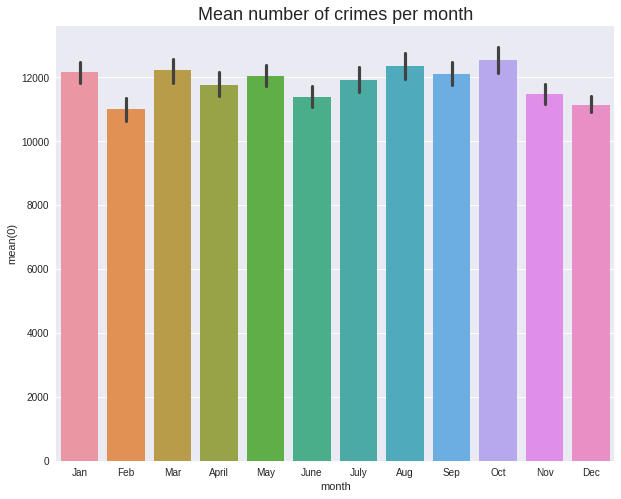

In [3]:
monthNames = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#we get rid of 2015 because it only has parital data
without2015 = allData[allData.year != 2015]

#group the data by month and year, then count the number of crimes in each group.
countByMonth = without2015.groupby(['year','month']).size().reset_index()

# sns.barplot will plot the means of each column. So we're plotting the mean of
# each month across all years in the data set.
ax = sns.barplot(x='month', y=0, data=countByMonth)
_ = ax.set_title('Mean number of crimes per month')
_ = ax.set_xticklabels(monthNames)

Separating the data by year gives us another way to look at things. If there indeed is a seasonal variation, then the all the plots should have a similar shape. What do you think?

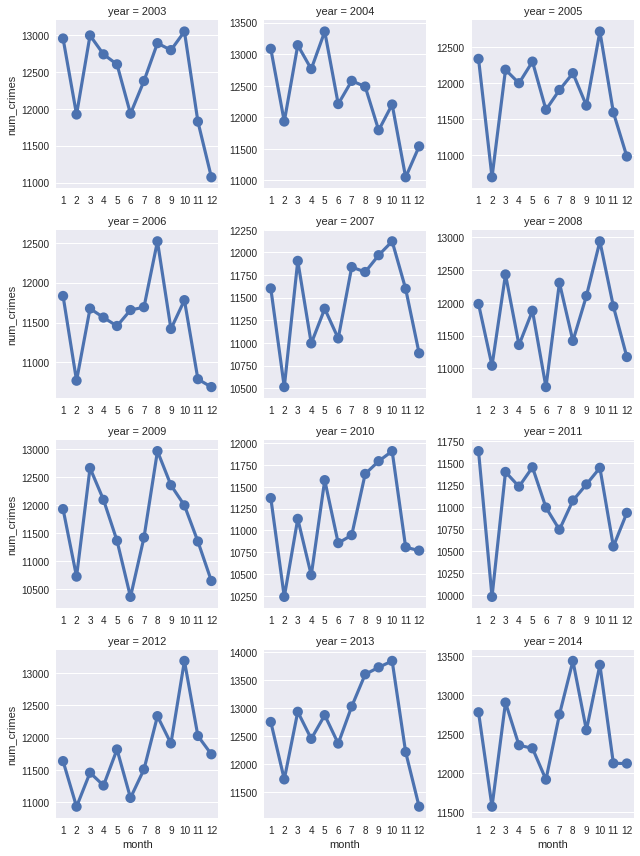

In [14]:
countByMonth = without2015.groupby(['year','month']).size().reset_index().rename(columns={0:'num_crimes'})
g = sns.FacetGrid(data=countByMonth, col='year', col_wrap=3, sharex=False, sharey=False)
g.map(sns.pointplot, 'month', 'num_crimes')

Here's a plot of the number of crimes in each month across the entire data set. Month 0 is January 2003 and month 143 is Decemeber 2014. The vertical red lines denote the start of a new year.

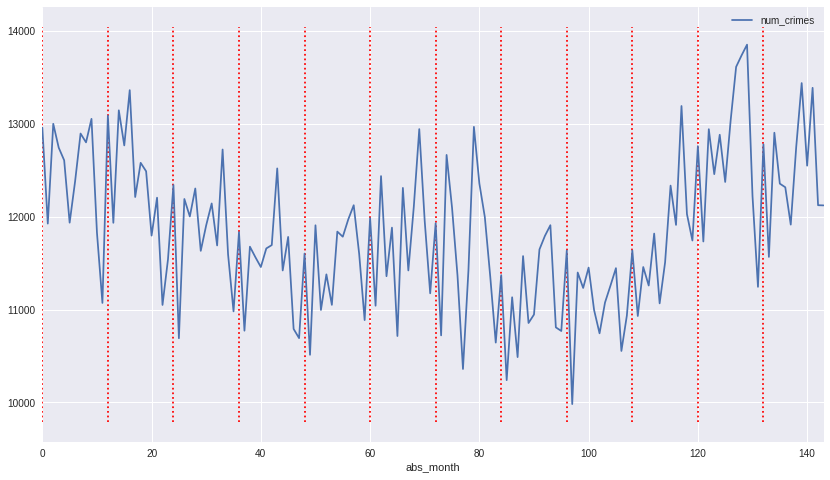

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
countByMonth.loc[:, 'abs_month'] = range(len(countByMonth))
countByMonth.plot('abs_month','num_crimes', ax=ax)
ymin, ymax = ax.get_ylim()
ax.vlines(range(0, len(countByMonth), 12), ymin, ymax, color='red', linestyles='dotted')

Could temperatures be associated with the number of crimes per month? Let's see.

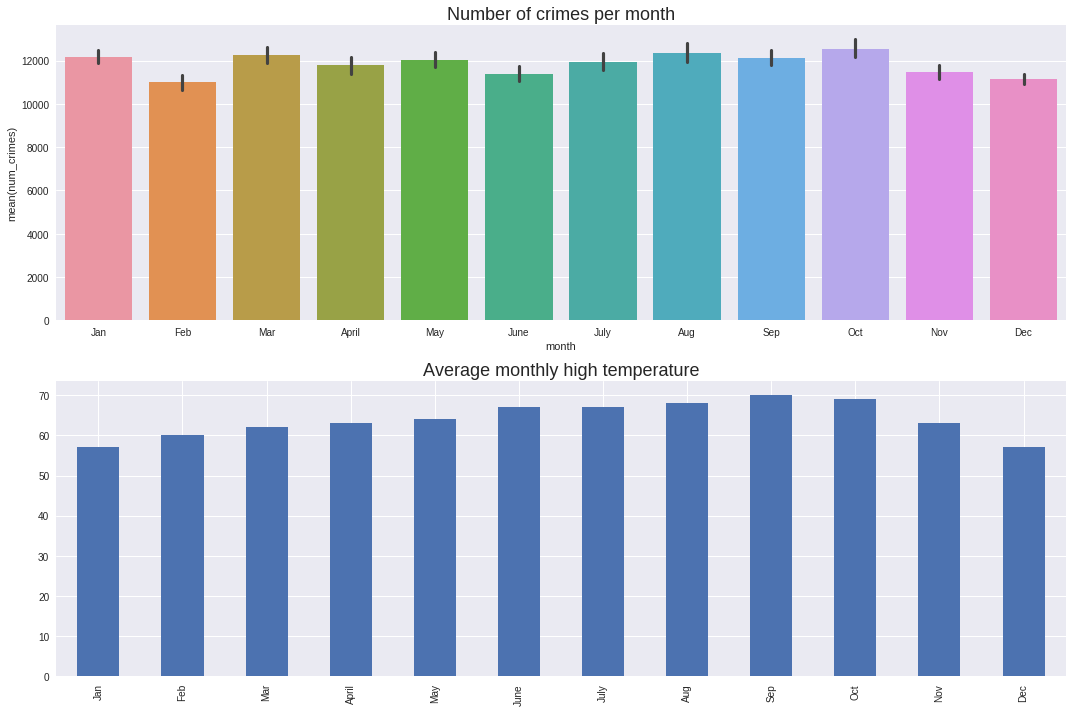

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sns.barplot(x='month', y='num_crimes', data=countByMonth,  ax=ax1)
ax1.set_title('Number of crimes per month')
ax1.set_xticklabels(monthNames)
sfAvgMonthlyMaxTemps = [57, 60, 62, 63, 64, 67, 67, 68, 70, 69, 63, 57] # According to weather.com
months = list(range(1,13))
tempSeries = pd.Series(sfAvgMonthlyMaxTemps, index=monthNames)
tempSeries.plot.bar(ax=ax2)
ax2.set_title('Average monthly high temperature')
fig.tight_layout()

Another way to look at temperature vs. crime.

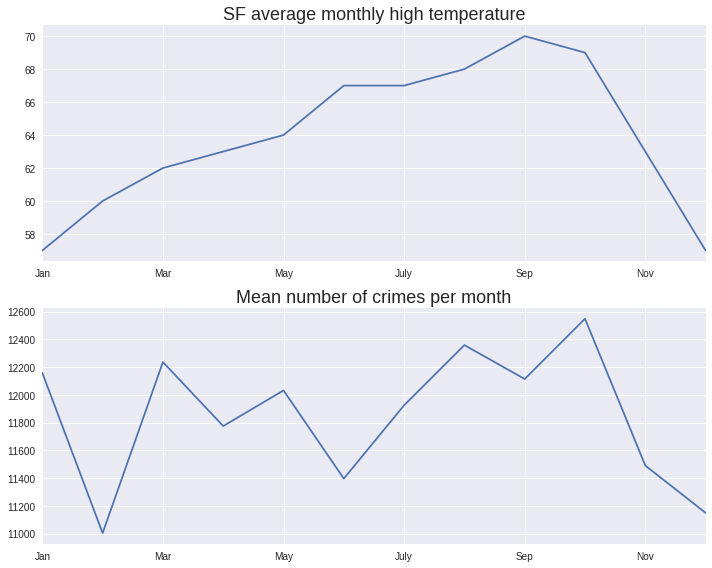

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1)
meanByMonth = countByMonth.groupby('month').num_crimes.mean()
meanByMonth.index=monthNames
tempSeries.plot(ax=ax1)
meanByMonth.plot(ax=ax2)
_ = ax1.set_title('SF average monthly high temperature')
_ = ax2.set_title('Mean number of crimes per month')
plt.tight_layout()

A scatterplot of temperature vs. average number of crimes per month

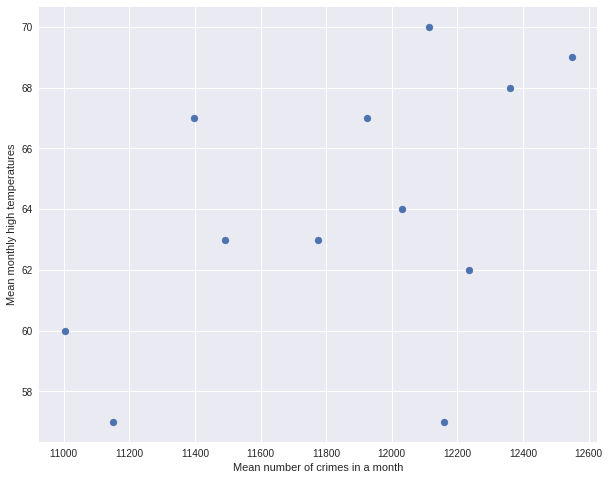

In [58]:
fig, ax = plt.subplots(1,1)
plt.scatter(countByMonth.groupby('month').agg({'num_crimes':'mean'}).values, sfAvgMonthlyMaxTemps)
ax.set_xlabel('Mean number of crimes in a month')
ax.set_ylabel('Mean monthly high temperatures')

So after looking at all those plots, what's the verdict?

I'd say there is a seasonal pattern, though it's far from perfect. For me, the strongest evidence comes from the plots where the data were separated by year. They show that January consistently has more crime than February, that there's a peak in September and October, and that crime usually falls off a bit after that.

However, I'm not sure this pattern can be explained by temperature, at least not fully. Why would January have so much more crime than other winter months? And why would the number of crimes zig zag during the spring, when temperatures are consistently rising? Below, we calculate the pearson correlation for the number of crimes and temperatures. It shows a moderate, though insignificant, association.

In [7]:
from scipy.stats import pearsonr
numCrimesMean = countByMonth.groupby('month').agg({'num_crimes':'mean'})
r, p_val =  pearsonr(numCrimesMean.num_crimes.values, sfAvgMonthlyMaxTemps)
print('Correlation Coefficient: {}, P-Value: {}'.format(r, p_val))

Correlation Coefficient: 0.493329031069, P-Value: 0.103141814938


Let's try one more thing. Let's group the data by the day of the year, and see which days have the most crime.

In [59]:
allData.groupby(['month', 'dayOfMonth']).size().reset_index().sort_values(by=0, ascending=False).head(10)

,month,dayOfMonth,0
0,1,1,7286
91,4,1,5988
60,3,1,5984
274,10,1,5836
305,11,1,5803
31,2,1,5791
121,5,1,5625
152,6,1,5539
244,9,1,5520
76,3,17,5394


That's interesting. January 1st has by far the most crime, and nine of the top ten days are the first of the month. Could there be some administrative procedure in the police department where more crimes get processed at the beginning of each month? Perhaps this gets magnified because in January because it's the beginning of the year? Or maybe it's just unruly revelers on New Year's Eve.

Regarding our seasonal variation/temperature question, if January 1st weren't such an outlier, the number of crimes in January would look a lot like those in February and December, and the seasonal/temperature association would be stronger.

## How does crime vary through the week?

Ok, let's narrow our view now look at weekly variation.

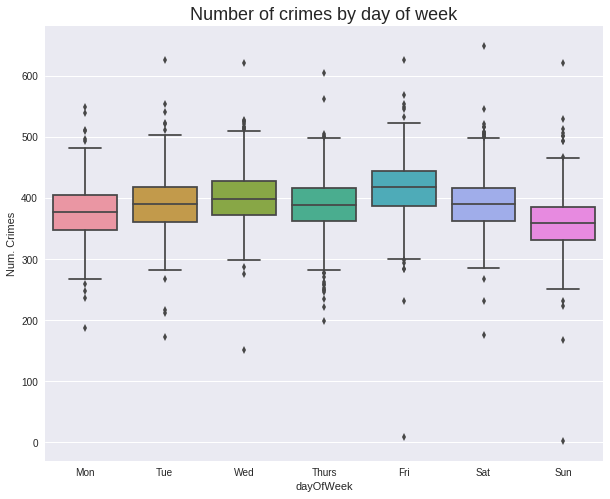

In [60]:
daysOfWeek = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
countByDayOfMonth = allData.groupby(['year', 'month', 'dayOfWeek', 'dayOfMonth']).size().reset_index()
ax = sns.boxplot(x='dayOfWeek', y=0, data=countByDayOfMonth)
_ = ax.set_ylabel('Num. Crimes')
_ = ax.set_xticklabels(daysOfWeek)
_ = ax.set_title('Number of crimes by day of week')

The least number of crimes occur on Sunday, while the most happen on Friday, which makes sense intuitively. It's also interesting to note that the days have very similar interquartile ranges, though the outlier spreads aren't quite as similar.

Let's look at how the weekly distribution changes as we take category into account. Notice that the plot above for all the categories combined looks a lot like the plots for the first few categories below. That's because the first few categories make up the majority of the total crimes. So they dominate the less prevalent categories in the combined plot. We'll also see this later on when we plot the number of crimes per hour.

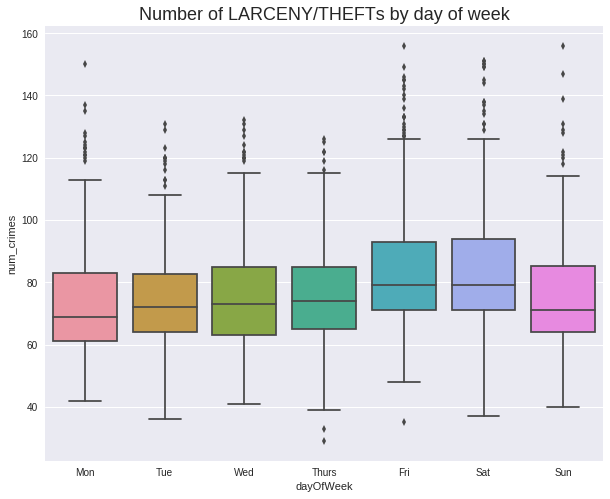

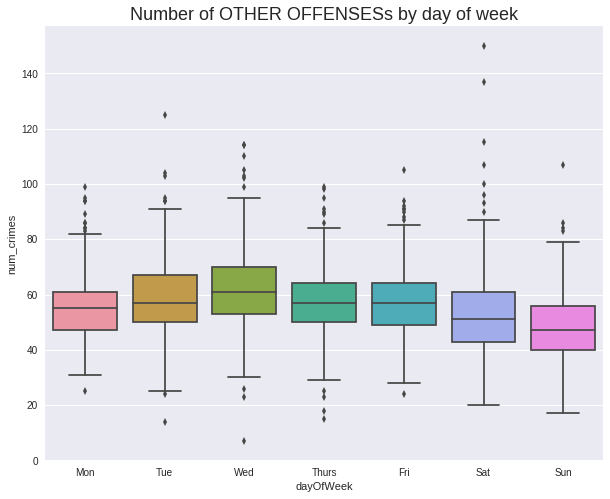

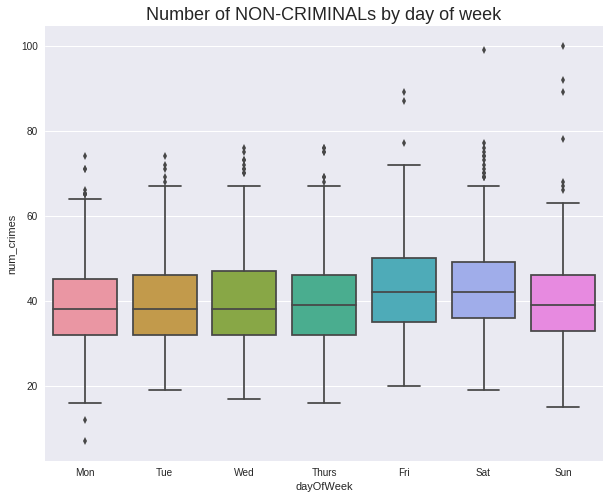

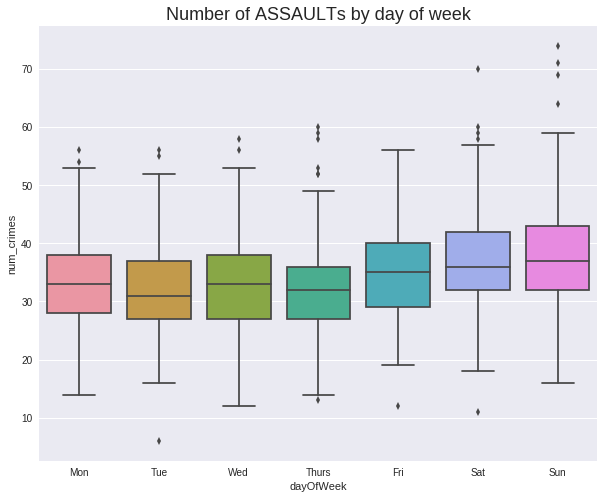

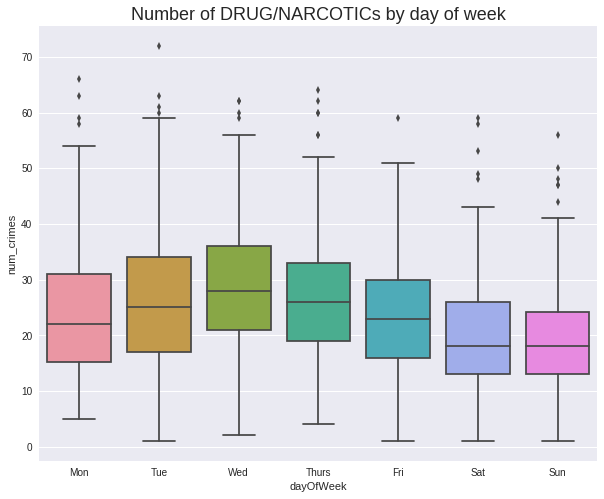

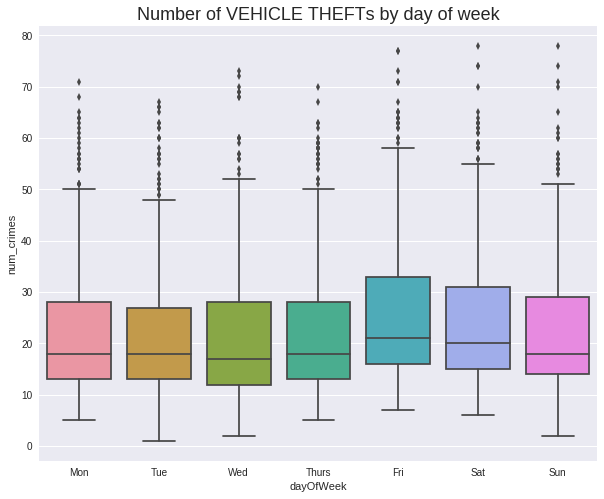

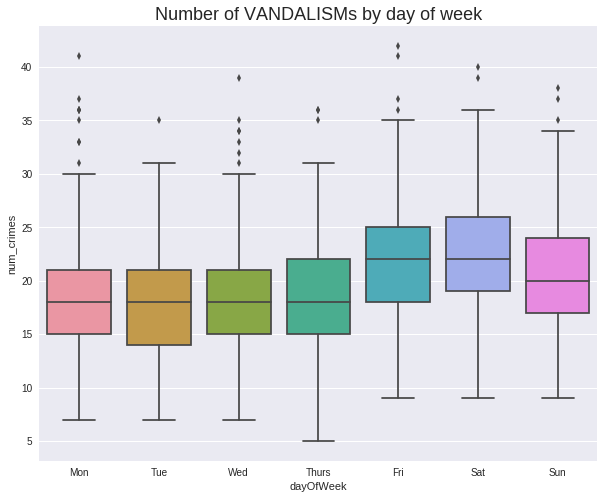

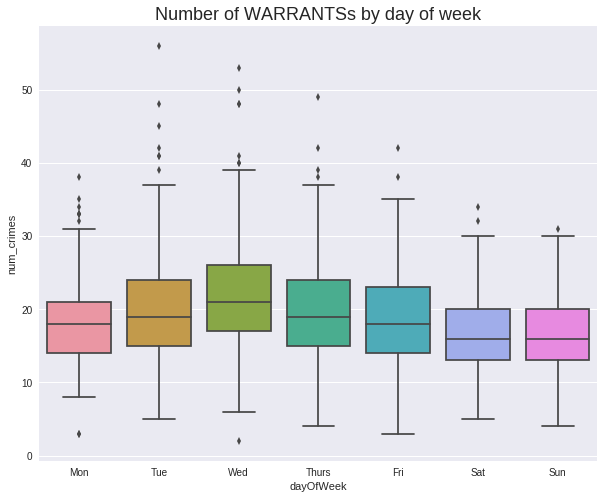

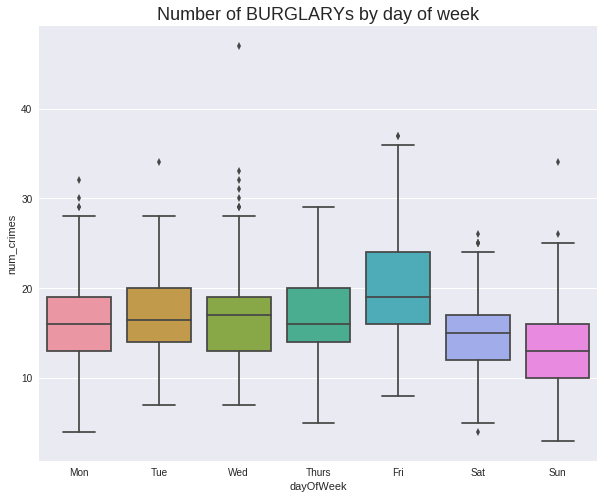

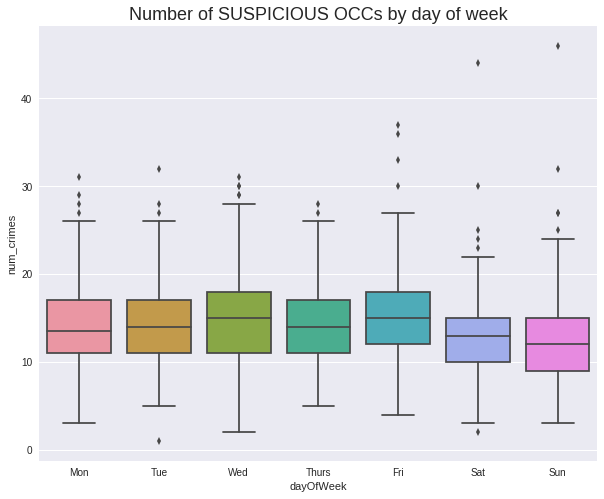

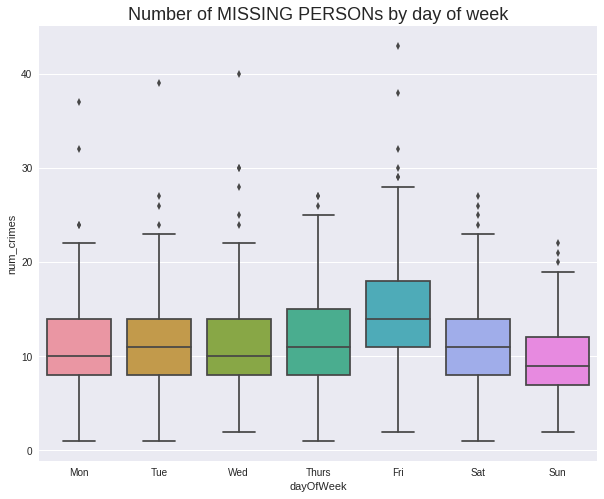

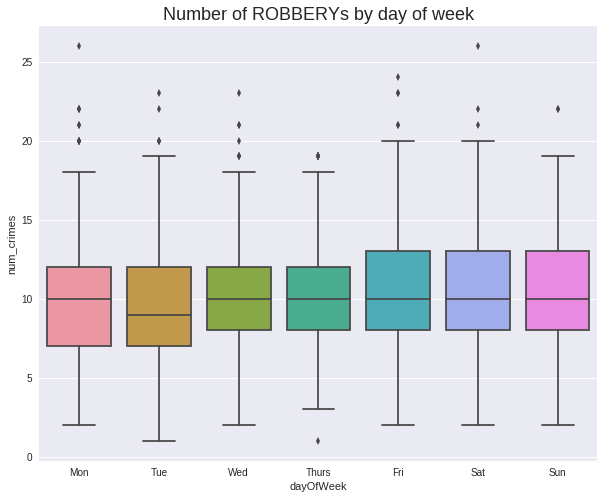

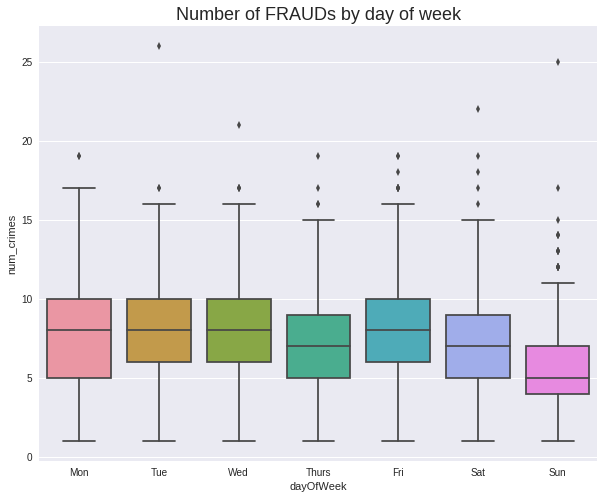

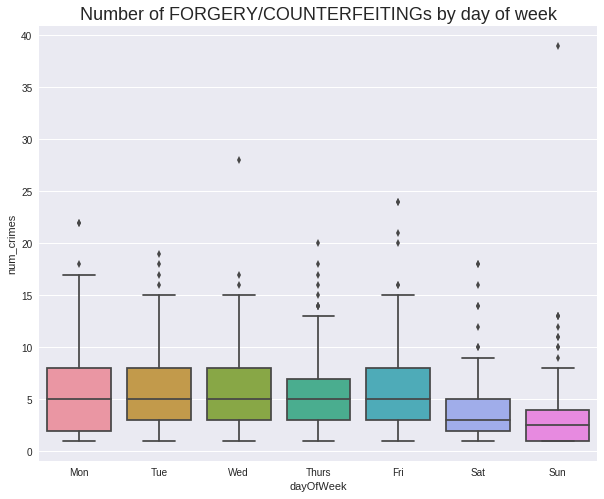

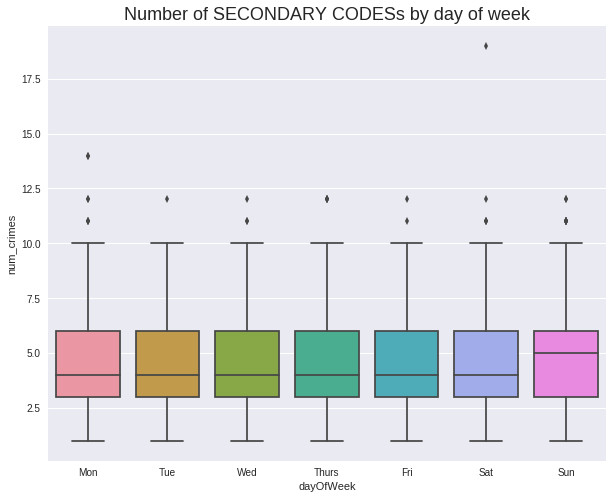

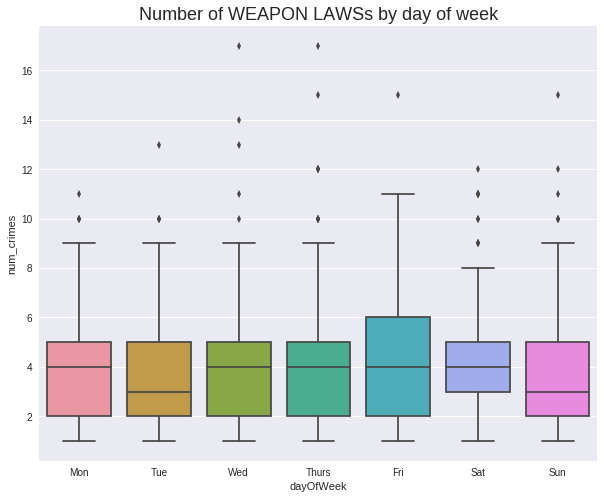

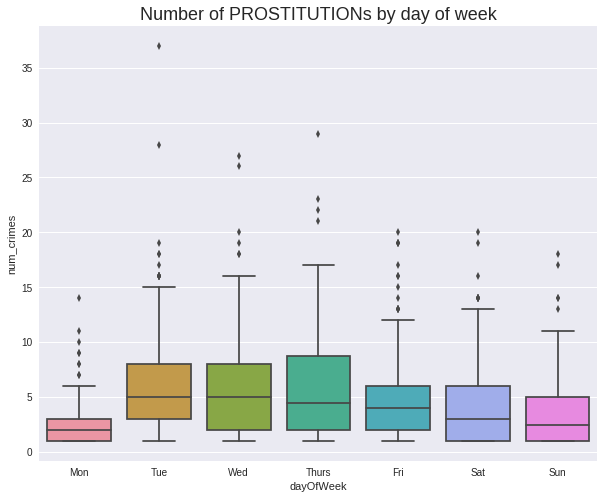

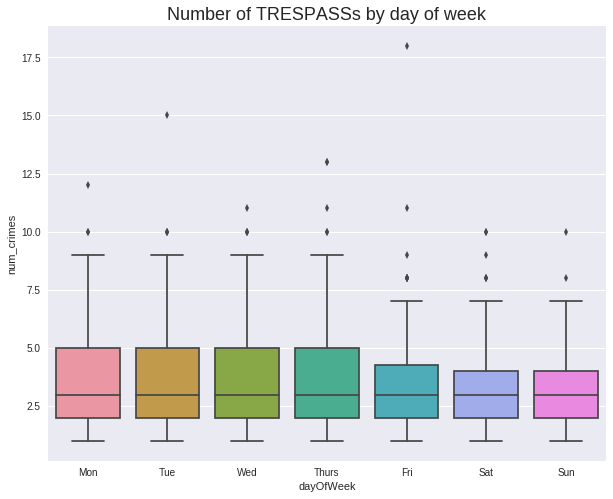

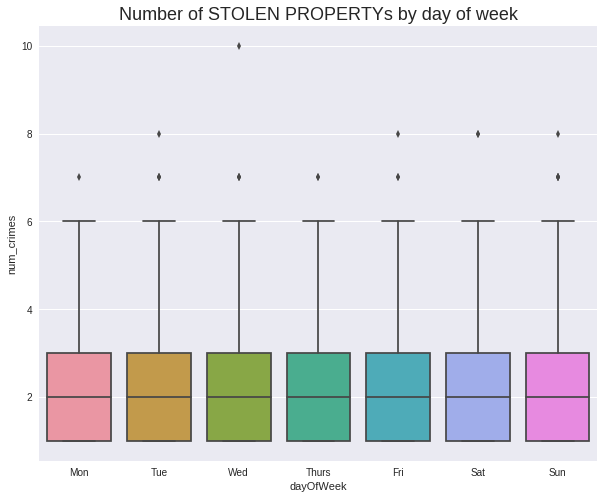

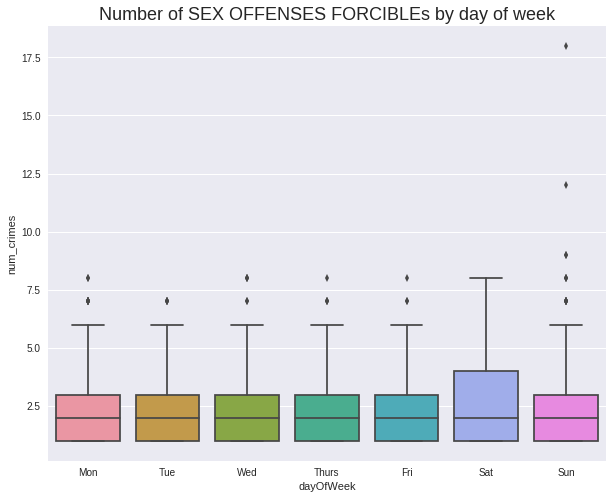

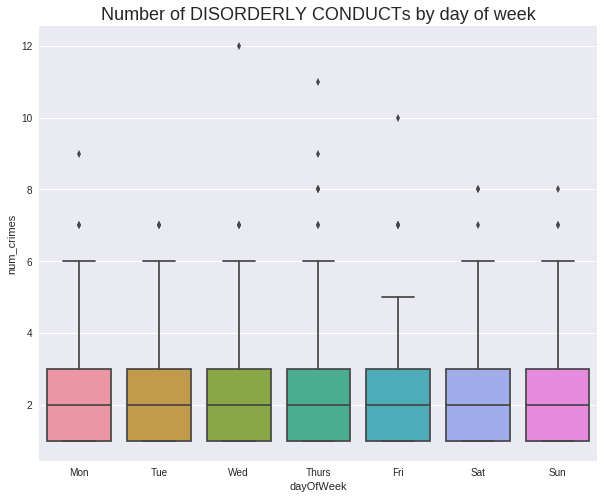

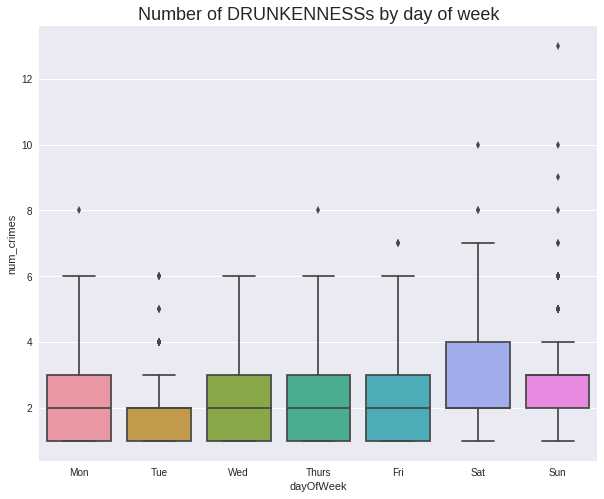

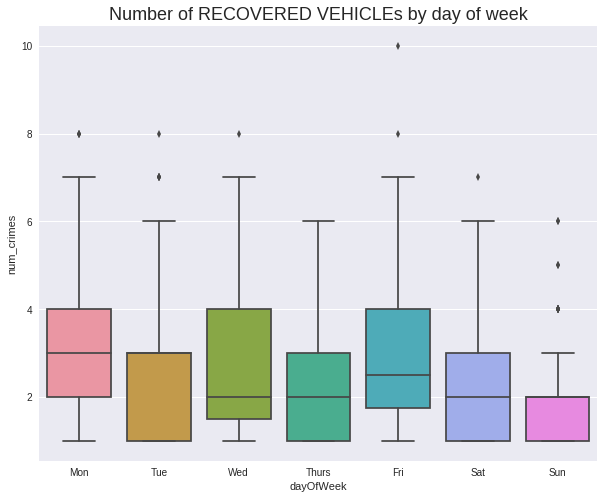

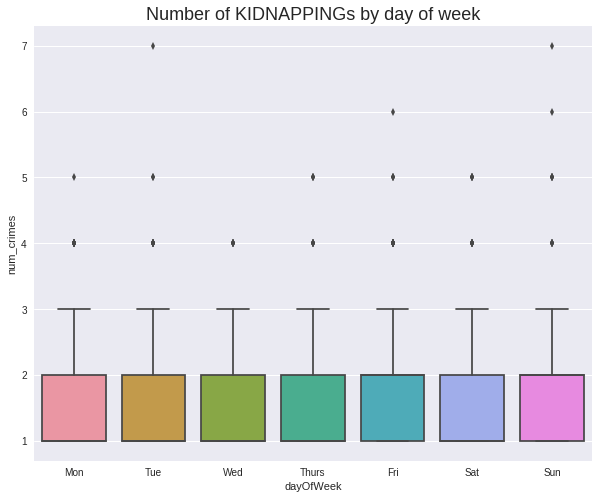

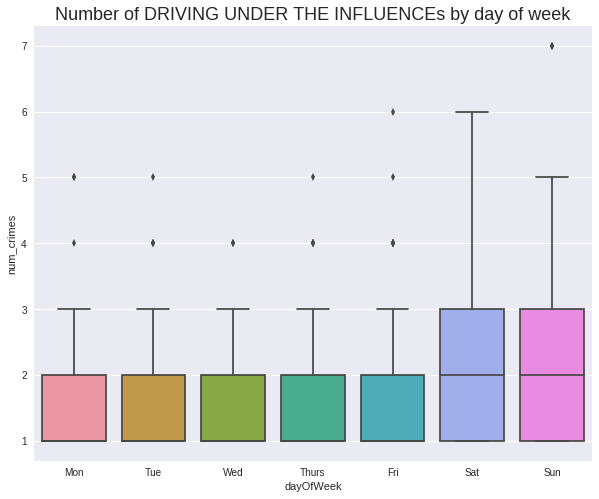

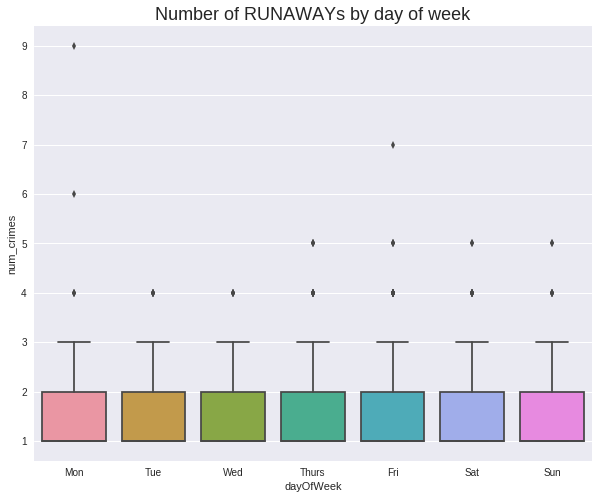

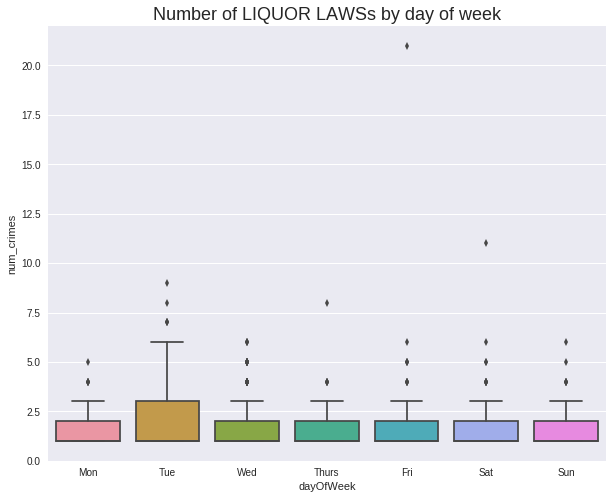

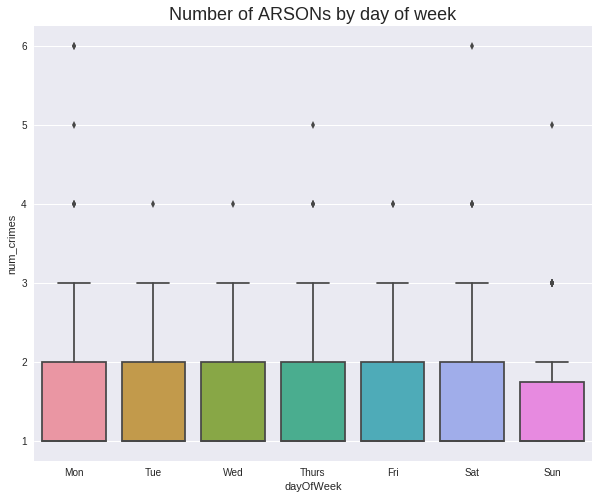

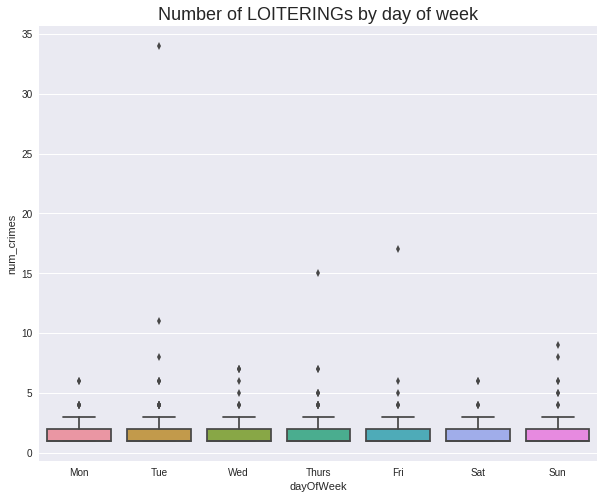

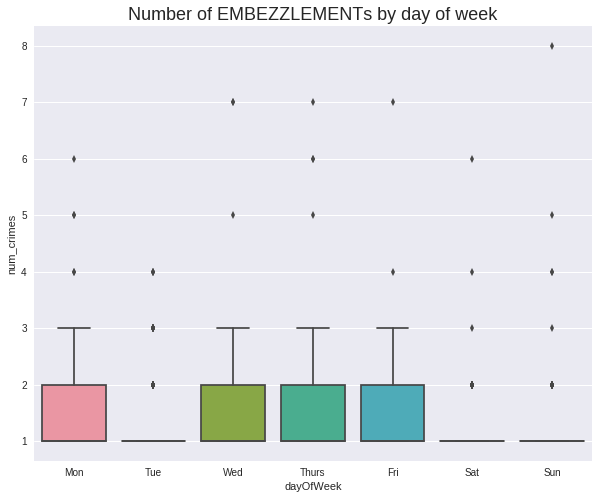

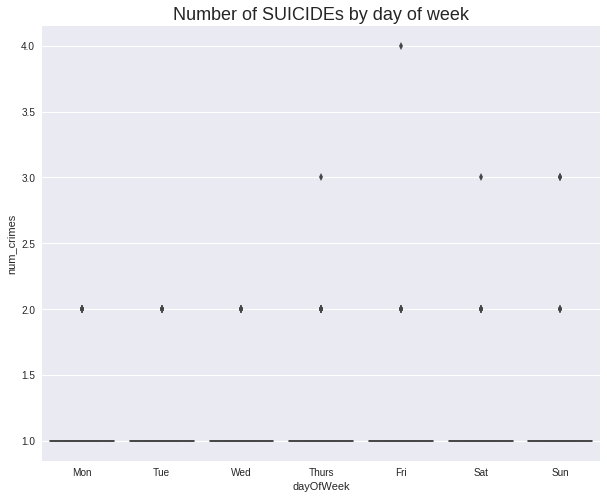

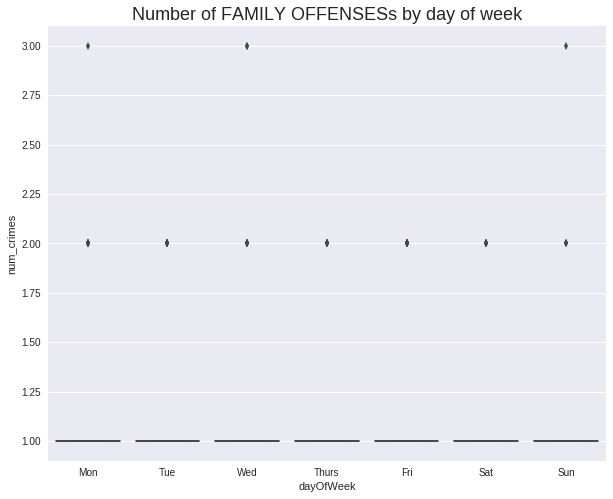

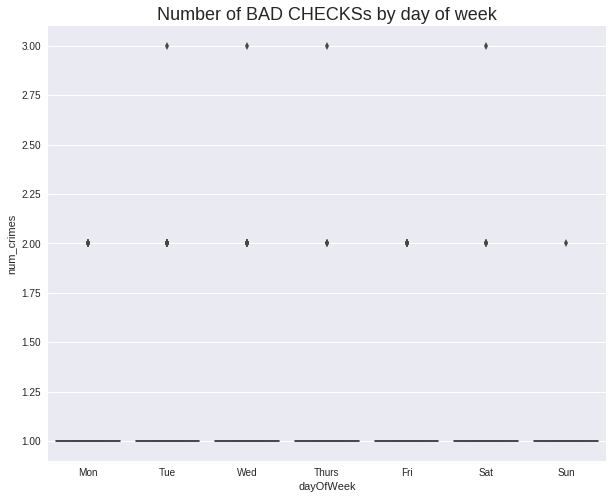

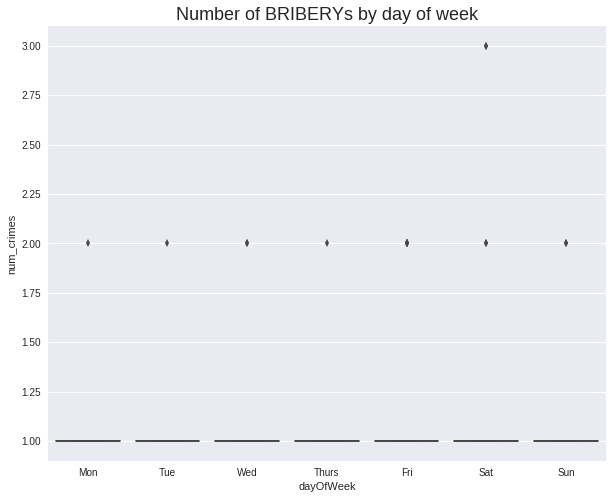

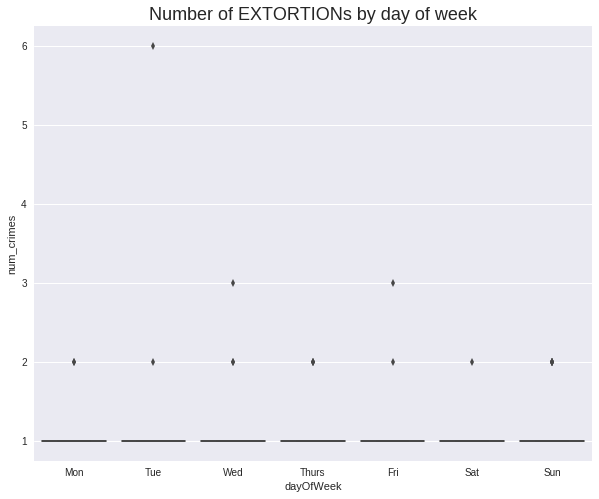

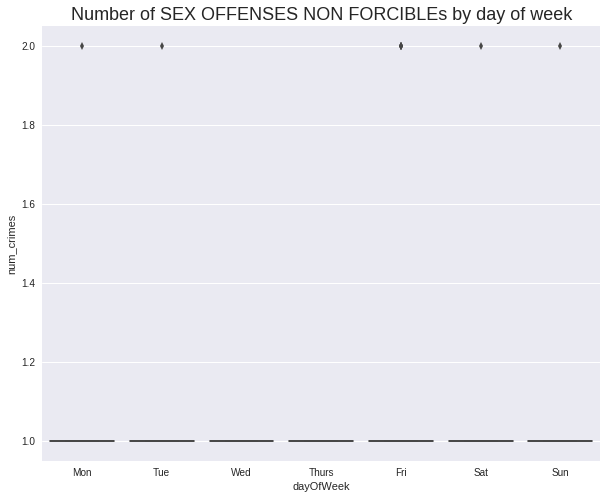

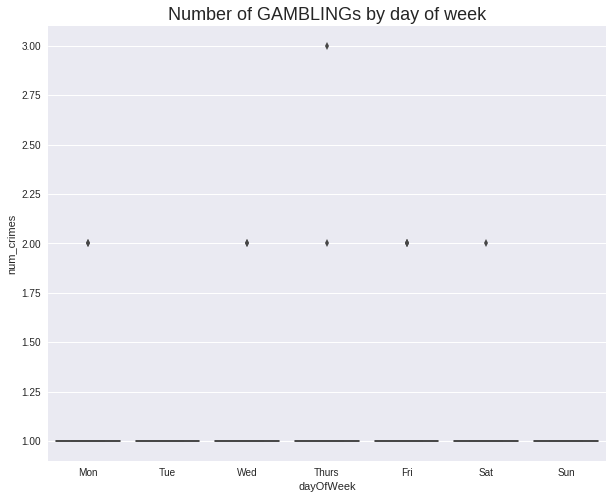

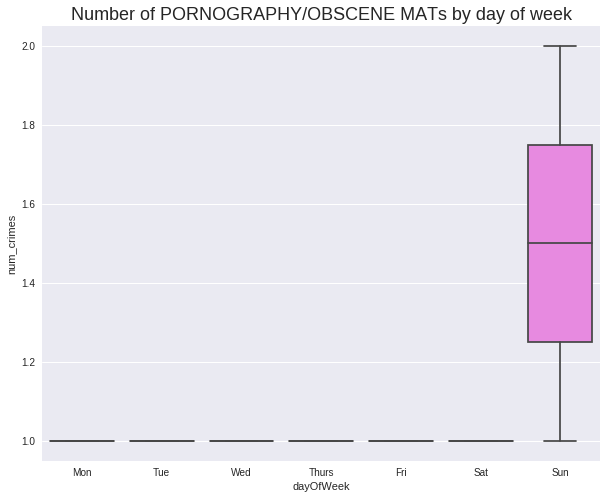

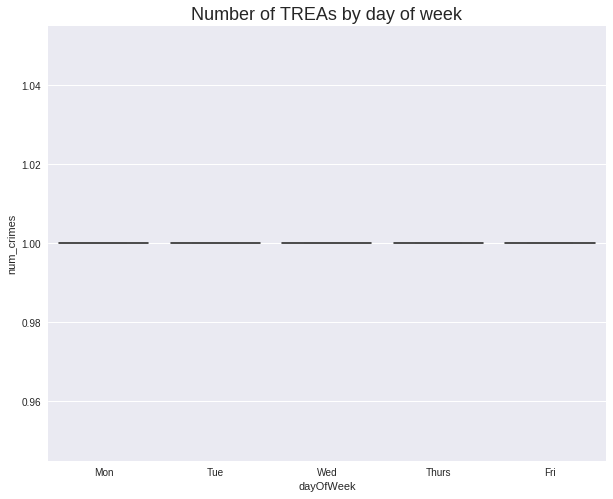

In [10]:
countByDayOfWeekCat = train.groupby(['year', 'month', 'dayOfWeek', 'dayOfMonth', 'Category']).size().reset_index()
countByDayOfWeekCat = countByDayOfWeekCat.rename(columns = {0:'num_crimes'})
for cat in train.Category.value_counts().index.values:
    ax = sns.boxplot(x='dayOfWeek', y='num_crimes', data=countByDayOfWeekCat[countByDayOfWeekCat.Category == cat])
    _ = ax.set_title('Number of {}s by day of week'.format(cat))
    _ = ax.set_xticklabels(daysOfWeek)
    plt.show()

Some things from the plots above that surprise me:
- drug/narcotics seems to peak on Wednesday. I thought it would be more prevalent on the weekends. The number of warrants seems to follow a similar pattern. Could they be related? Maybe the narcotics team serves their warrants early in the week?
- missing persons spikes prominently on Friday. Wonder why.
- prostitution is highest on Monday, Tuesday and Wednesday. Could that also have something to do with policing tactics?


## How does crime vary by time of day?

Let's hone in on how crime varies by time of day.

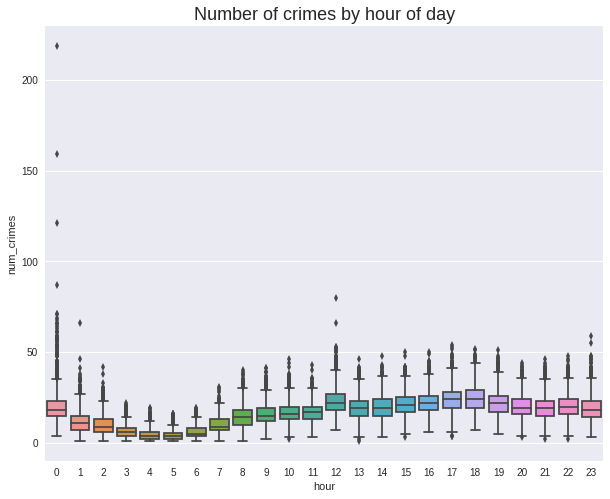

In [11]:
countByHours = train.groupby(['year', 'month', 'dayOfMonth', 'hour']).size().reset_index().rename(columns={0: 'num_crimes'})
ax = sns.boxplot(x='hour', y='num_crimes', data=countByHours)
_ = ax.set_title('Number of crimes by hour of day')

Above we see the rise and fall of crime throughout the day. The fewest crimes are committed around 5am and a peak is reached around 6pm, from which point it begins falling again. The slight uptick at noon is interesting, as are the outliers for midnight. Let's take a look at those outliers.

In [12]:
topCrimeHours = countByHours.sort_values(by='num_crimes', ascending=False).head()
topCrimeHours

,year,month,dayOfMonth,hour,num_crimes
34637,2011,1,1,0,219
12998,2006,1,1,0,159
38991,2012,1,1,0,121
46971,2013,11,1,0,87
13010,2006,1,1,12,80


Ah, so the four highest crime hours were on January first between 12am and 1am -- it may have been New Year's revelers after all that were causing the uptick of crime in January that we saw earlier. Let's look at the top categories for the first hour of the year.

In [13]:
train[(train.hour == 0) & (train.month == 1) & (train.dayOfMonth == 1)].Category.value_counts().head(10)

OTHER OFFENSES            149
NON-CRIMINAL               80
LARCENY/THEFT              48
SUSPICIOUS OCC             41
ASSAULT                    34
FRAUD                      29
FORGERY/COUNTERFEITING     25
VANDALISM                  21
SEX OFFENSES FORCIBLE      19
MISSING PERSON             14
Name: Category, dtype: int64

Hmmm,  I would have expected drunkeness to be one of the top categories of crime. Perhaps other offenses includes partying offenses?

Enough partying..now let's plot the mean number of crimes per hour for each category of crime.

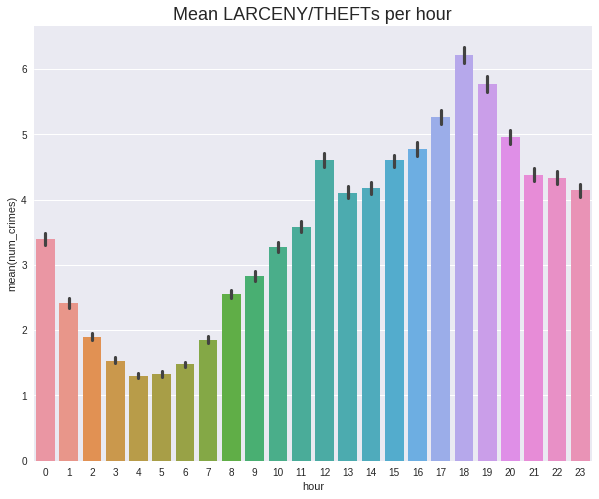

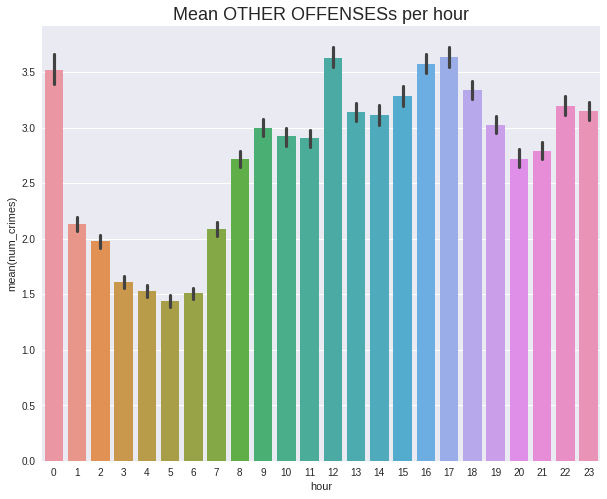

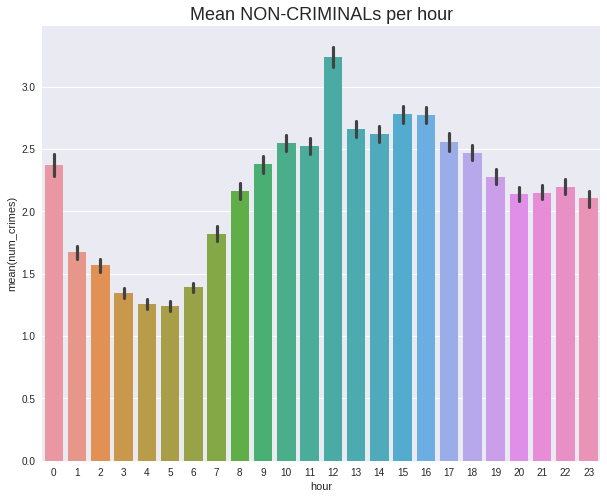

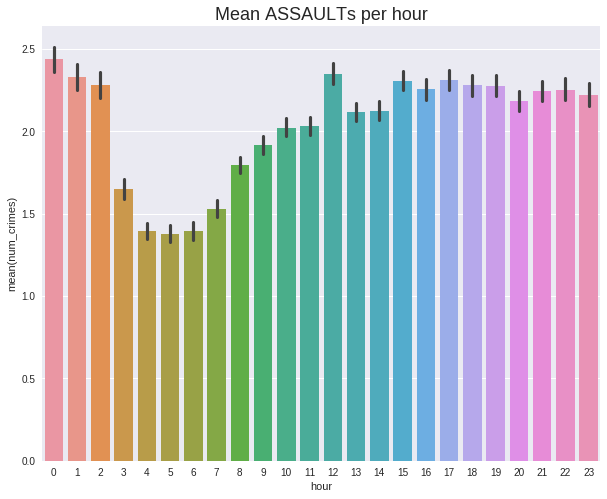

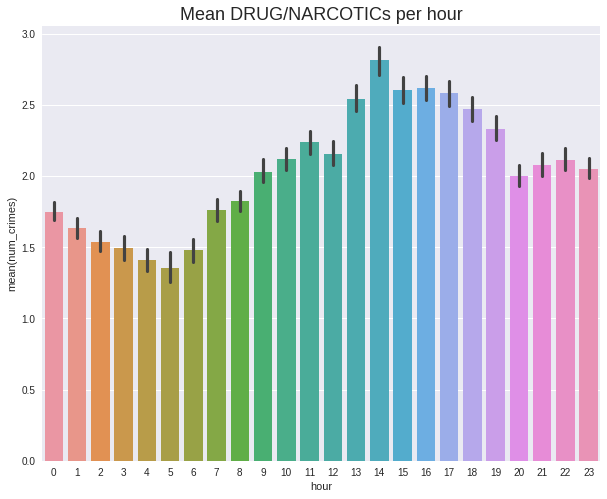

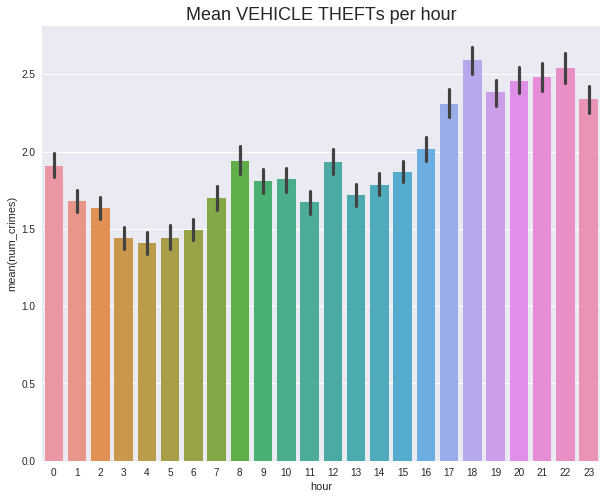

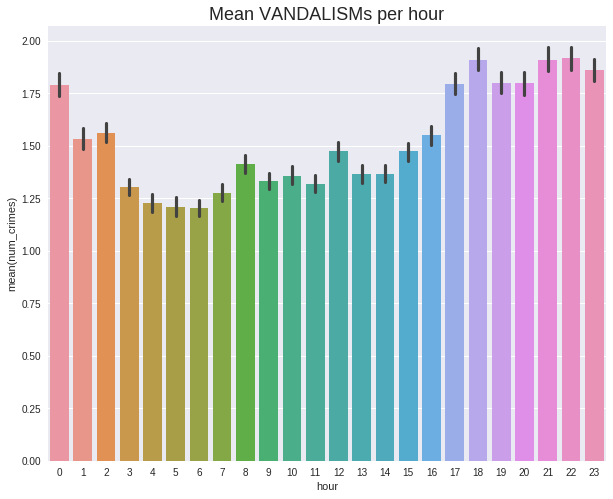

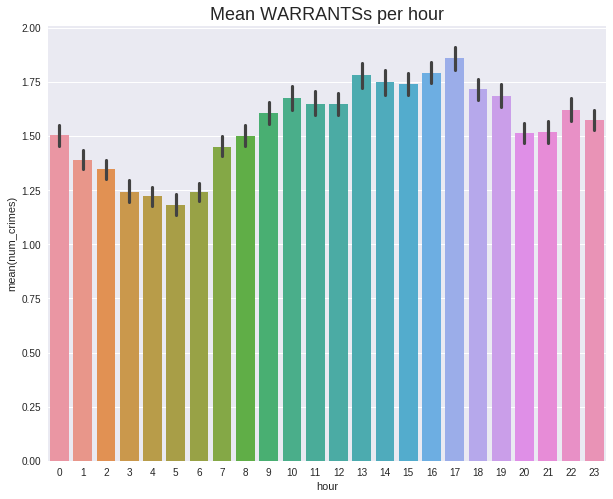

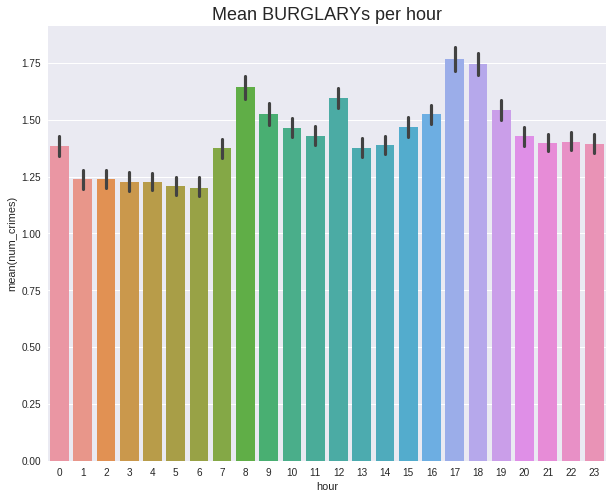

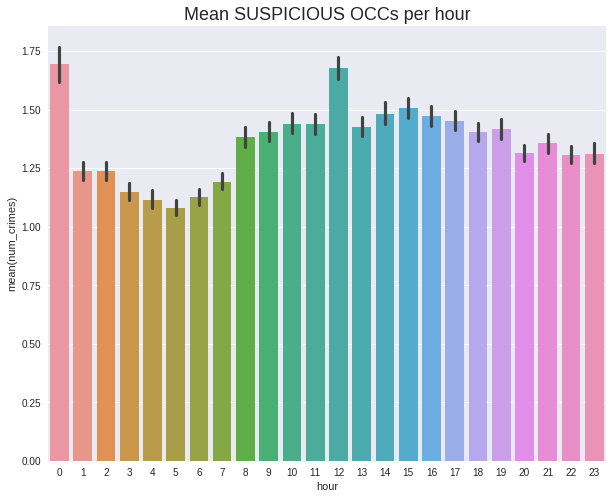

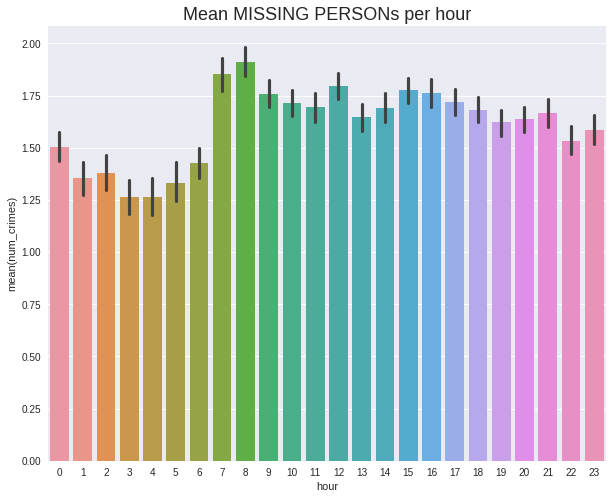

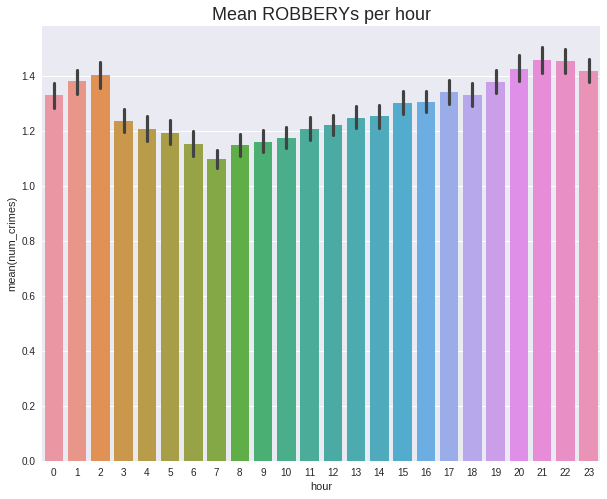

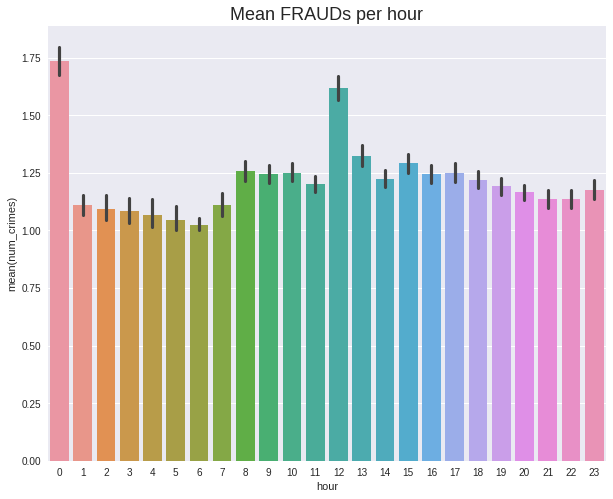

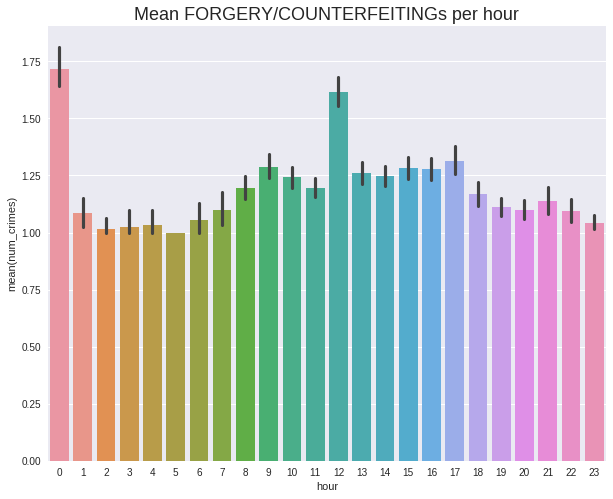

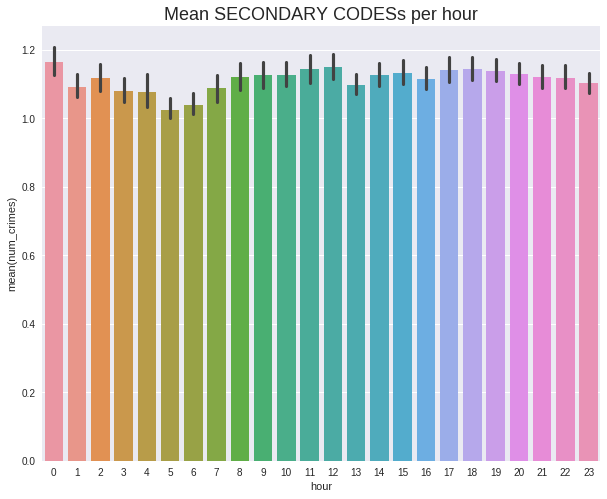

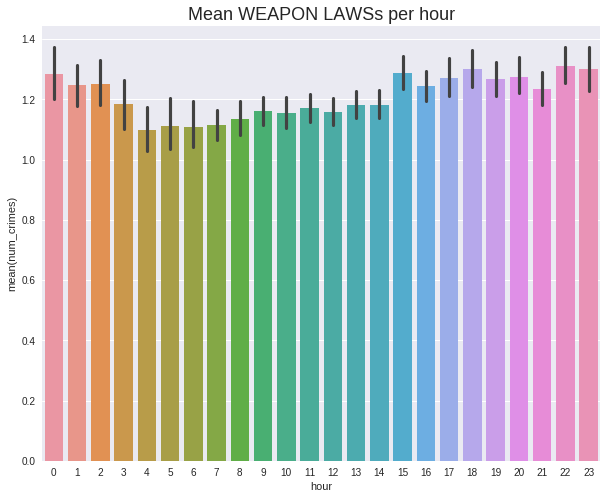

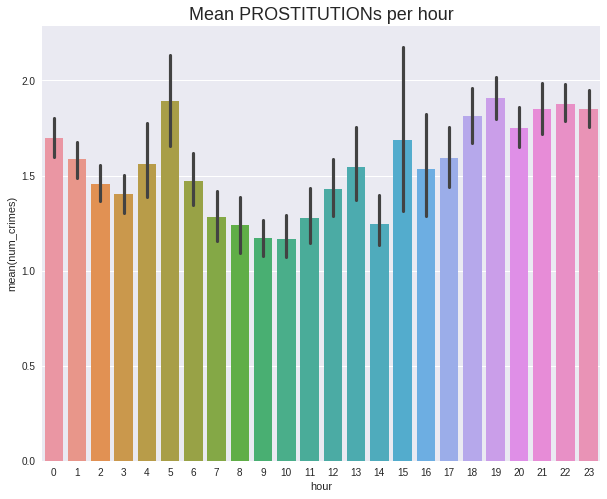

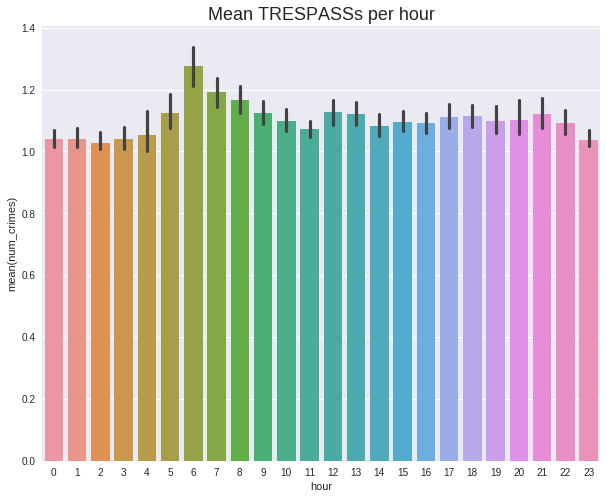

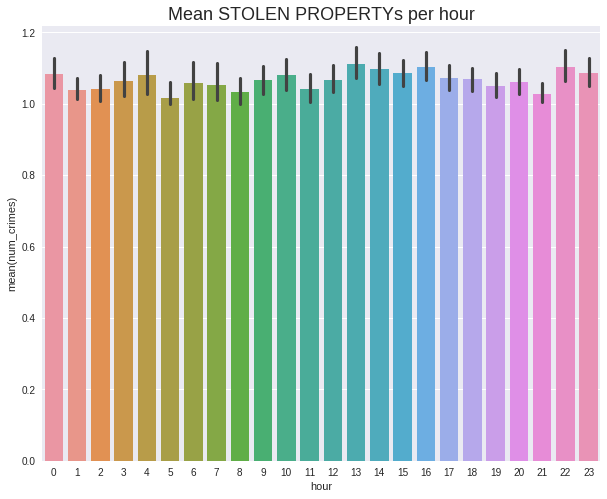

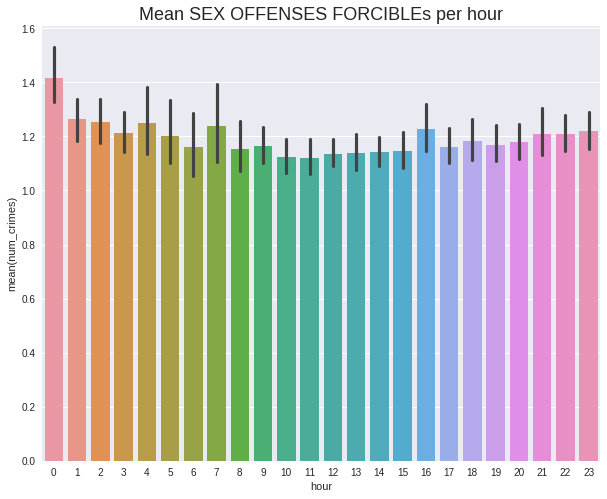

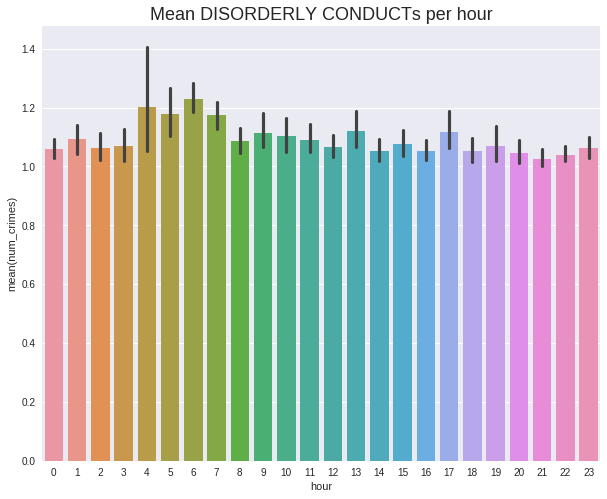

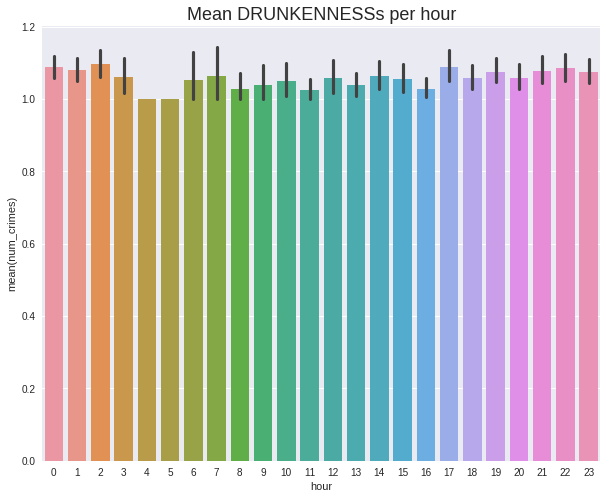

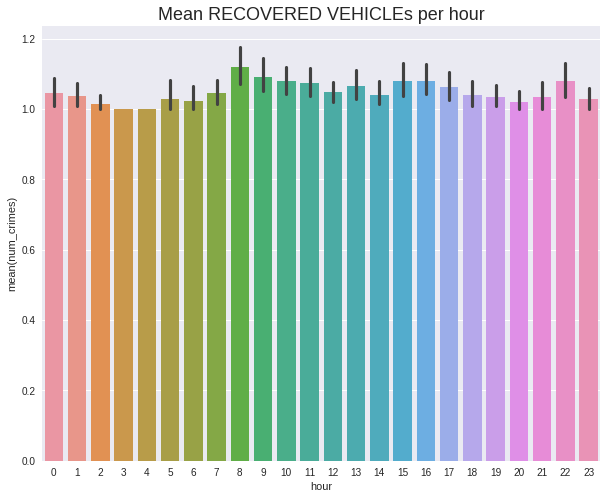

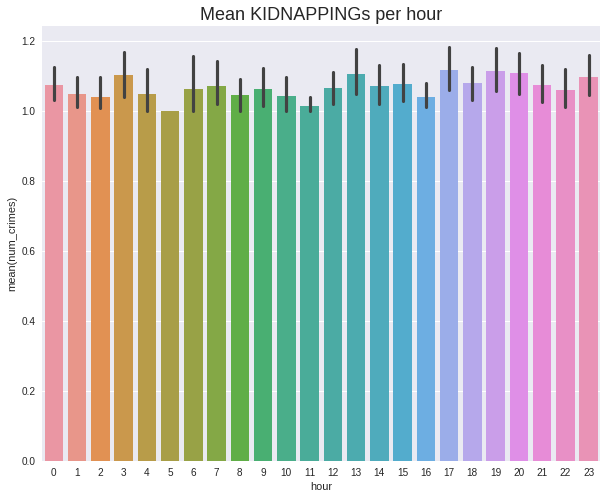

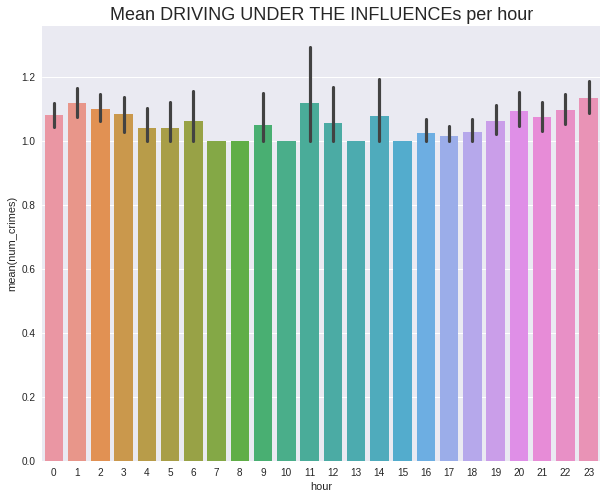

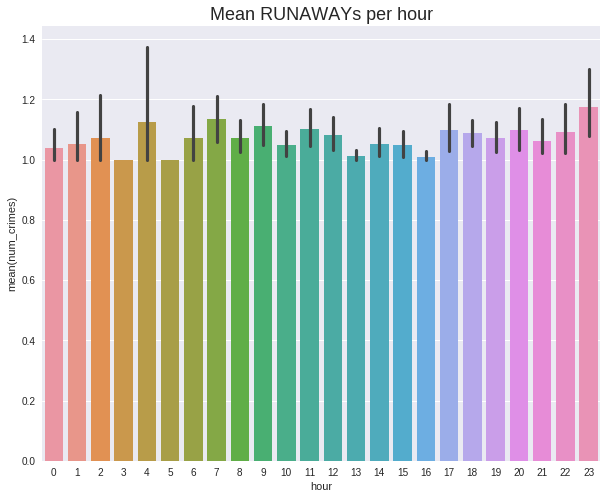

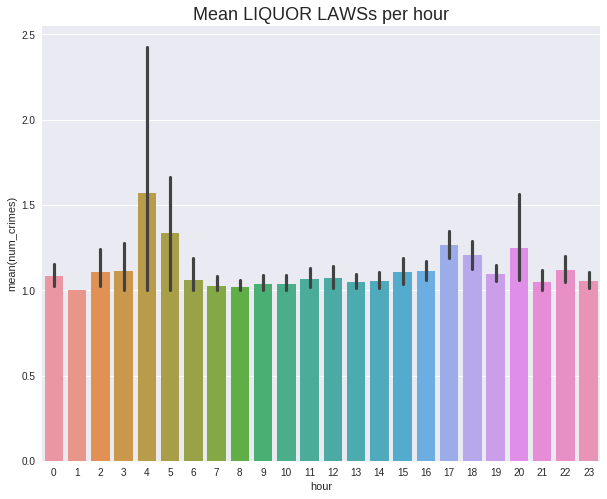

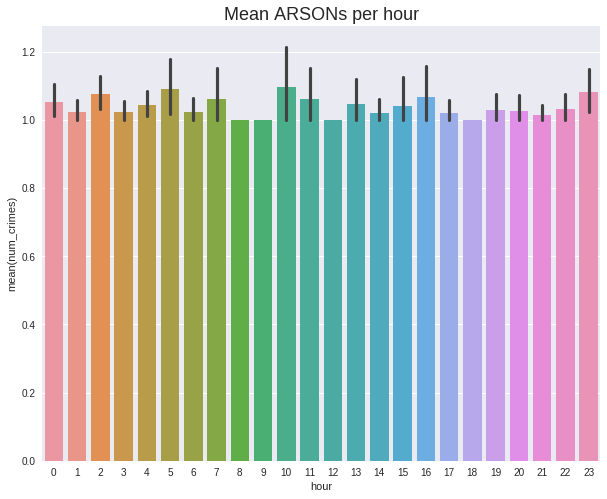

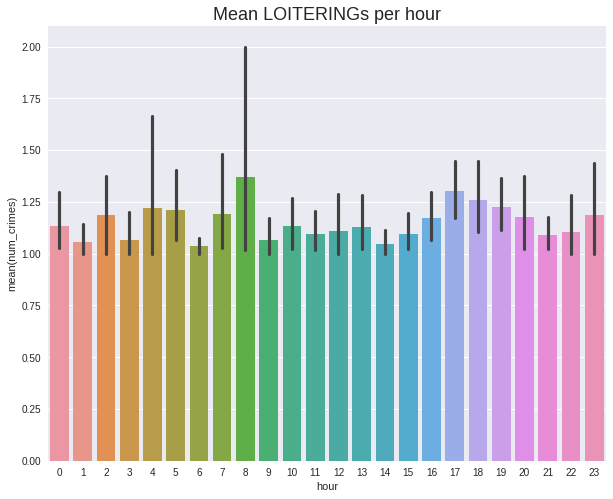

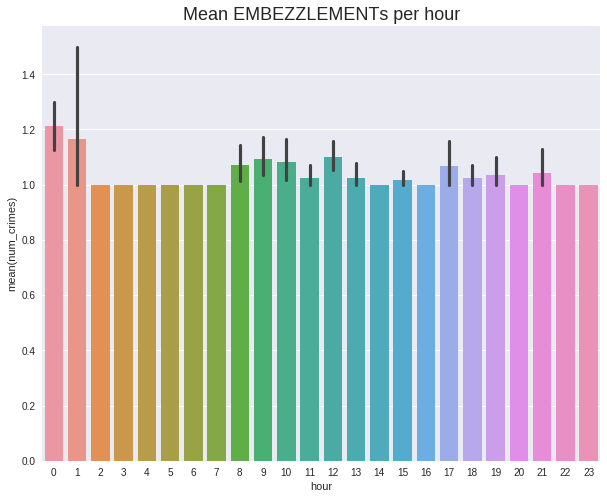

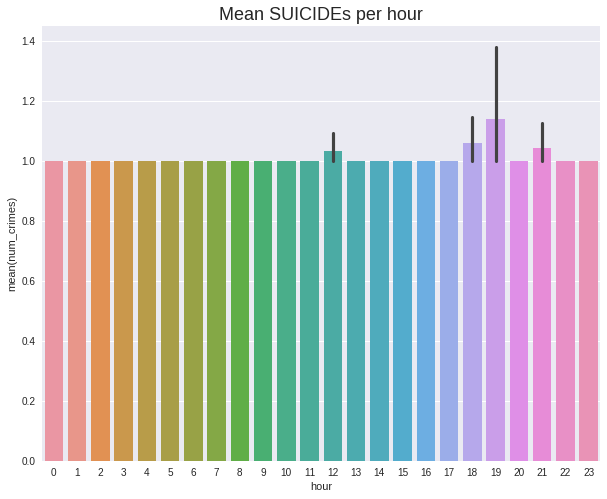

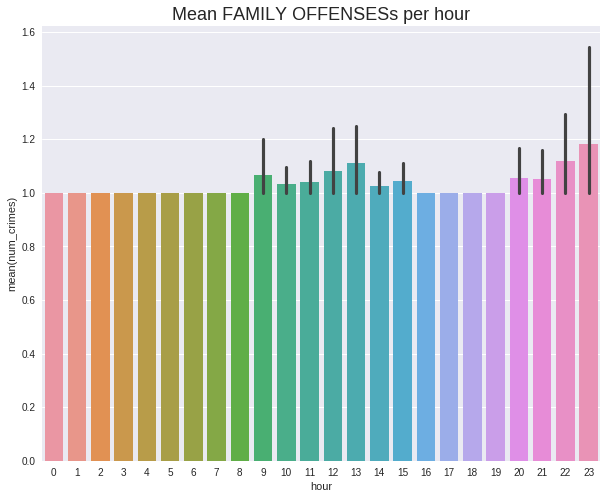

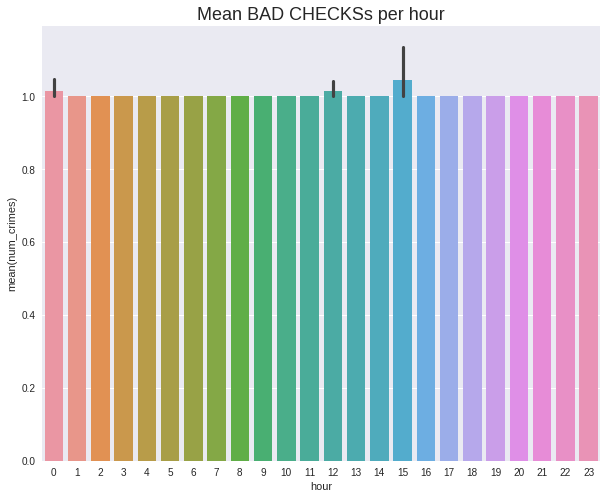

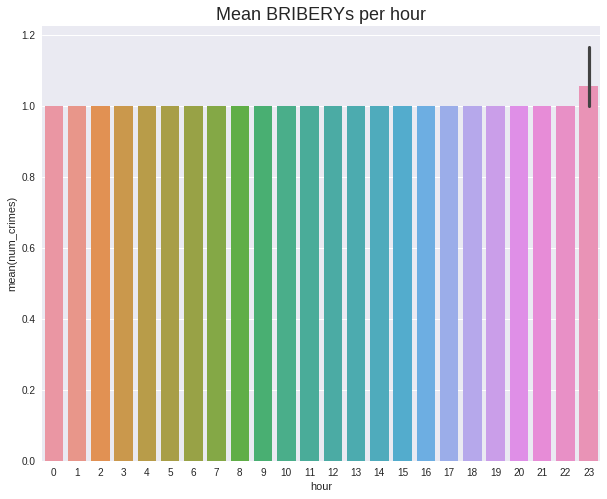

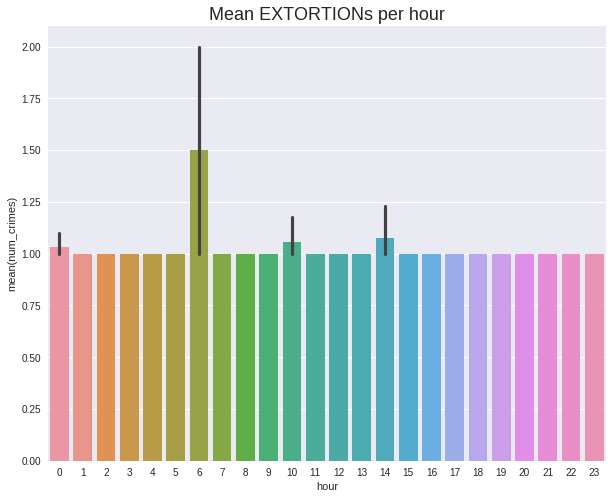

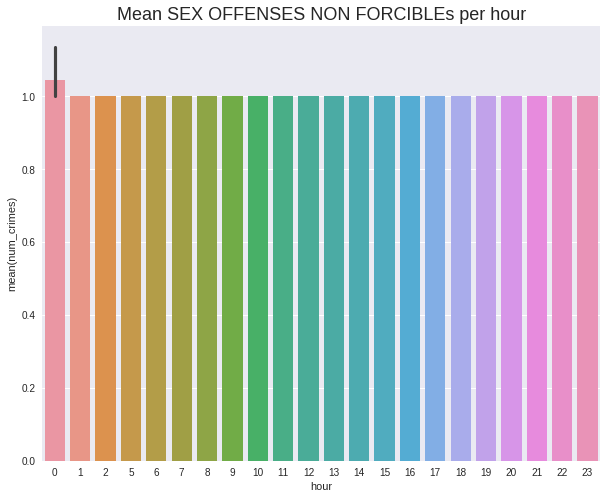

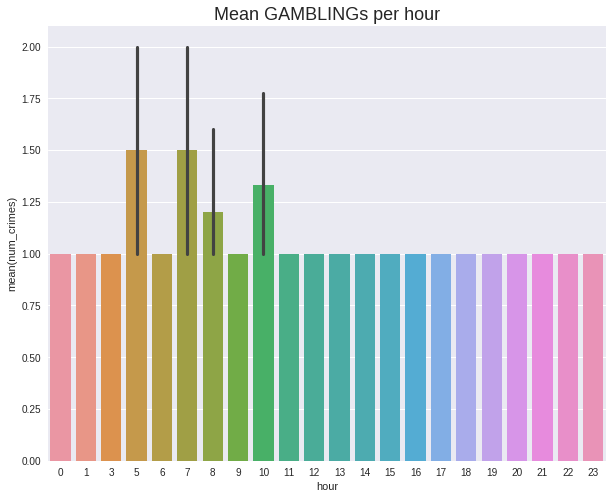

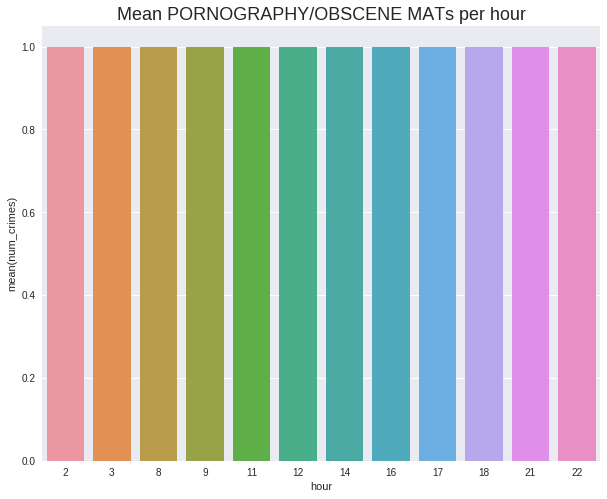

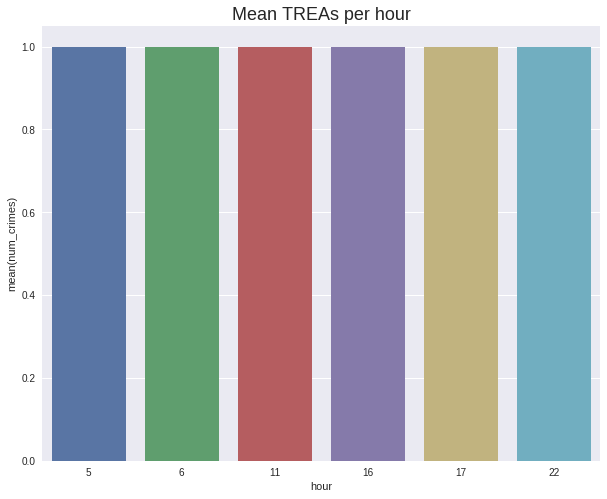

In [14]:
countByHourCat = train.groupby(['year', 'month', 'dayOfMonth', 'hour', 'Category']).size().reset_index().rename(columns={0: 'num_crimes'})

for cat in train.Category.value_counts().index.values:
    ax = sns.barplot(x='hour', y='num_crimes', data=countByHourCat[countByHourCat.Category == cat])
    _ = ax.set_title('Mean {}s per hour'.format(cat))
    plt.show()

 Again, some things I find interesting:
- Drugs/Narcotics peaks during the middle of the afternoon
- Missing/Persons peak at 7 or 8am. Is that because people wake up and find that someone has not returned during the night as expected?
- Fraud and forgery/counterfeiting show significant spikes at midnight and noon. Why?
- I would have expected a higher proportion of DUIs to occur during the evening/night than during the day. The distribution seems more uniform than I would have thought.